# About the data

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. The classification problem is to identify the newsgroup a post was summited to, given the text of the post.

There are a few versions of this dataset from different sources online. Below, we use the version within scikit-learn which is already split into a train and test/eval set. For a longer introduction to this dataset, see the [scikit-learn website](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)

This sequence of notebooks will write files to the file system under the WORKSPACE_PATH folder. Feel free to change this location in the next cell.

In [4]:
# Note this path must be under /content/datalab in Datalab.
# It is not recommended to use paths in /content/datalab/docs
WORKSPACE_PATH = '/content/datalab/workspace/tf/text_classification_20newsgroup'
!mkdir -p {WORKSPACE_PATH}

import os
os.chdir(WORKSPACE_PATH)

In [5]:
import numpy as np
import pandas as pd
import os
import re
import csv

from sklearn.datasets import fetch_20newsgroups

In [10]:
# data will be downloaded. Note that an error message saying something like "No handlers could be found for 
# logger sklearn.datasets.twenty_newsgroups" might be printed, but this is not an error.
news_train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
news_test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

No handlers could be found for logger "sklearn.datasets.twenty_newsgroups"


# Inspecting and cleaning the raw data

The distribution of labels/newsgroups within the training and test datasets are almost uniform. But more importantly, the distribution between test and training is about the same. Note that the first column is the integer id for the newsgroup while the 2nd column is the number of text examples with this newsgroup label.

Printing the 3rd element in the test dataset shows the data contains text with newlines, punctuation, misspellings, and other items common in text documents. To build a model, we will clean up the text by removing some of these issues.

In [4]:
news_train_data.data[2], news_train_data.target_names[news_train_data.target[2]]

(u'well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is tha

In [11]:
def clean_and_tokenize_text(news_data):
    """Cleans some issues with the text data
    Args:
        news_data: list of text strings
    Returns:
        For each text string, an array of tokenized words are returned in a list
    """
    cleaned_text = []
    for text in news_data:
        x = re.sub('[^\w]|_', ' ', text)  # only keep numbers and letters and spaces
        x = x.lower()
        x = re.sub(r'[^\x00-\x7f]',r'', x)  # remove non ascii texts
        tokens = [y for y in x.split(' ') if y] # remove empty words
        tokens = ['[number]' if x.isdigit() else x for x in tokens]

        # As an exercise, try stemming each token using python's nltk package.
        cleaned_text.append(tokens)
    return cleaned_text

In [12]:
clean_train_tokens = clean_and_tokenize_text(news_train_data.data)
clean_test_tokens = clean_and_tokenize_text(news_test_data.data)

In [13]:
def get_unique_tokens_per_row(text_token_list):
    """Collect unique tokens per row.
    Args:
        text_token_list: list, where each element is a list containing tokenized text
    Returns:
        One list containing the unique tokens in every row. For example, if row one contained
        ['pizza', 'pizza'] while row two contained ['pizza', 'cake', 'cake'], then the output list
        would contain ['pizza' (from row 1), 'pizza' (from row 2), 'cake' (from row 2)]
    """
    words = []
    for row in text_token_list:
        words.extend(list(set(row)))
    return words

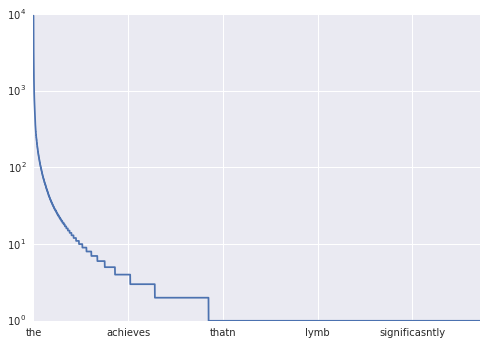

In [14]:
# Make a plot where the x-axis is a token, and the y-axis is how many text documents
# that token is in. 
words = pd.DataFrame(get_unique_tokens_per_row(clean_train_tokens) , columns=['words'])
token_frequency = words['words'].value_counts() # how many documents contain each token.
token_frequency.plot(logy=True)

Note that most of our tokens only appear in 1 document, while some appears almost every document. To build a good model, we should remove these low frequency tokens.

In [15]:
len(news_train_data.data), len(token_frequency)  # There are many more tokens than examples!

(11314, 94231)

In [16]:
# Filter tokens.
vocab = token_frequency[token_frequency > 10]

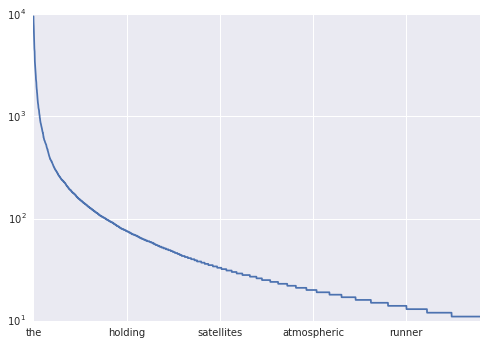

In [17]:
vocab.plot(logy=True)

In [18]:
import six 

CONTROL_WORDS = ['<s>', '</s>', '<unk>']

vocab_id = {v[0]: idx + 1 for idx, v in enumerate(sorted(six.iteritems(vocab), key=lambda x: x[1], reverse=True))}
for c in CONTROL_WORDS:
  vocab_id[c] = len(vocab_id)

In [19]:
def filter_text_by_vocab(news_data, vocab_id):
    """Removes tokens if not in vocab.
    Args:
        news_data: list, where each element is a token list
        vocab: set containing the tokens to keep.
    Returns:
        List of strings containing the final cleaned text data
    """
    wids_all = []
    for row in news_data:
        wids = [vocab_id[token] if (token in vocab_id) else vocab_id['<unk>'] for token in row]
        wids = [vocab_id['<s>']] + wids + [vocab_id['</s>']]
        wids = wids[:128]
        wids_all.append(wids)
    return wids_all
  
clean_train_data = filter_text_by_vocab(clean_train_tokens, vocab_id)
clean_test_data = filter_text_by_vocab(clean_test_tokens, vocab_id)  

In [20]:
# As a check, let's make sure we didn't remove any data rows.
len(clean_train_data), len(news_train_data.data), len(clean_test_data), len(news_test_data.data)

(11314, 11314, 7532, 7532)

In [21]:
# vocab size
len(vocab_id)

9587

In [22]:
def pad_wids(wids, length):
    """Pad each instance to """
    padded = []
    for r in wids:
        if len(r) >= length:
            padded.append(r[0:length])
        else:
            padded.append(r + [0] * (length - len(r)))
    return padded
  
padded_train_data = pad_wids(clean_train_data, 128)
padded_test_data = pad_wids(clean_test_data, 128)  

# Build a DNN model

We'll first build a simple DNN model with only 3 layers: input, embeddings, and output.

In [23]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
from google.datalab.ml import Summary

TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 512
EMBEDDING_SIZE = 512

In [24]:
def dnn_model(batch_size, train_data, targets, mode):
    """Build an DNN Model. """
    
    with tf.name_scope(mode):
        raw_data = tf.convert_to_tensor(train_data, dtype=tf.int64)
        targets = tf.convert_to_tensor(targets, dtype=tf.int64)
        batch_num = len(train_data) // batch_size - 1
        i = tf.train.range_input_producer(batch_num, shuffle=True).dequeue()
        input_seqs = raw_data[i * batch_size: (i + 1) * batch_size]
        targets = targets[i * batch_size: (i + 1) * batch_size]
        length = tf.count_nonzero(input_seqs, axis=1, dtype=tf.int32)

    embedding_map = tf.get_variable(
        name="embeddings_map",
        shape=[len(vocab_id), EMBEDDING_SIZE])
    seq_embeddings = tf.nn.embedding_lookup(embedding_map, input_seqs)
    
    # Simply combine embeddings.
    combined = tf.sqrt(tf.reduce_sum(tf.square(seq_embeddings), 1))

    logits = tf.contrib.layers.fully_connected(
        inputs=combined,
        num_outputs=20,
        activation_fn=None)

    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)
    losses= tf.reduce_mean(cross_entropy, name='xentropy_mean')
    predictions = tf.argmax(logits, 1)
    _, accuracy = tf.contrib.metrics.streaming_accuracy(targets, predictions)
    correct_predictions = tf.count_nonzero(tf.equal(predictions, targets))
    return losses, accuracy, correct_predictions

In [29]:
def train(model_fn, train_steps, model_dir):
    """Model trainer."""

    g = tf.Graph()
    with g.as_default():
        uniform_initializer = tf.random_uniform_initializer(minval=-0.08, maxval=0.08)
        with tf.variable_scope("Model", reuse=None, initializer=uniform_initializer):
            losses_train, _, _ = model_fn(TRAIN_BATCH_SIZE, padded_train_data, news_train_data.target, 'train')
        with tf.variable_scope("Model", reuse=True):
            _, accuracy, correct_predictions = model_fn(EVAL_BATCH_SIZE, padded_test_data, news_test_data.target, 'eval')

        tf.summary.scalar('accuracy', accuracy)        
        tf.summary.scalar('losses', losses_train)  
        merged = tf.summary.merge_all()        
        
        global_step = tf.Variable(
            initial_value=0,
            name="global_step",
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
        train_op = tf.contrib.layers.optimize_loss(
            loss=losses_train,
            global_step=global_step,
            learning_rate=0.001,
            optimizer='Adam')

    def train_step_fn(sess, *args, **kwargs):
        total_loss, should_stop = tf.contrib.slim.python.slim.learning.train_step(sess, *args, **kwargs)

        if train_step_fn.train_steps % 50 == 0:
            summary = sess.run(merged)
            train_step_fn.eval_writer.add_summary(summary, train_step_fn.train_steps)
            total_correct_predictions = 0
            num_eval_batches = len(padded_test_data) / EVAL_BATCH_SIZE
            for i in range(len(padded_test_data) / EVAL_BATCH_SIZE):
                total_correct_predictions += sess.run(correct_predictions)
            print('accuracy: %.4f' % (float(total_correct_predictions)/(num_eval_batches*EVAL_BATCH_SIZE)))

        train_step_fn.train_steps += 1
        return [total_loss, should_stop] 

    train_step_fn.train_steps = 0
    train_step_fn.eval_writer = tf.summary.FileWriter(os.path.join(model_dir, 'eval'))

    tf.contrib.slim.learning.train(
        train_op,
        model_dir,
        graph=g,
        global_step=global_step,
        number_of_steps=train_steps,
        log_every_n_steps=50,  
        train_step_fn=train_step_fn)
    train_step_fn.eval_writer.close()

In [35]:
# Start from fresh. Note that you can skip this step to continue training from previous checkpoint.
!rm -rf dnn

In [36]:
train(dnn_model, train_steps=1501, model_dir='dnn')

INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path dnn/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
accuracy: 0.0532
INFO:tensorflow:global step 50: loss = 2.8257 (0.041 sec/step)
accuracy: 0.1692
INFO:tensorflow:global step 100: loss = 2.3956 (0.042 sec/step)
accuracy: 0.3608
INFO:tensorflow:global step 150: loss = 2.1872 (0.040 sec/step)
accuracy: 0.5296
INFO:tensorflow:global step 200: loss = 1.5957 (0.039 sec/step)
accuracy: 0.5988
INFO:tensorflow:global step 250: loss = 1.5946 (0.040 sec/step)
accuracy: 0.6339
INFO:tensorflow:global step 300: loss = 1.3473 (0.038 sec/step)
accuracy: 0.6441
INFO:tensorflow:global step 350: loss = 0.9924 (0.038 sec/step)
accuracy: 0.6684
INFO:tensorflow:global step 400: loss = 0.7074 (0.039 sec/step)
accuracy: 0.6596
INFO:tensorflow:global step 450: loss = 0.8210 (0.038 sec/step)
accuracy: 0.6685
INFO:tensorflow:global step 500: loss = 0.7930 (0.0

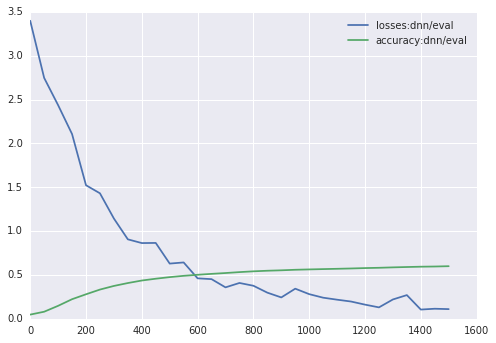

In [37]:
summary = Summary('dnn/eval')
summary.plot(['losses', 'accuracy'])

# Build a bidirectional LSTM model

Let's try an LSTM based sequential model and see if it can beat DNN.

In [38]:
LSTM_SIZE=128

def lstm_model(batch_size, train_data, targets, mode):
    """Build an LSTM Model. """
    
    with tf.name_scope(mode):
        raw_data = tf.convert_to_tensor(train_data, dtype=tf.int64)
        targets = tf.convert_to_tensor(targets, dtype=tf.int64)
        batch_num = len(train_data) // batch_size - 1
        i = tf.train.range_input_producer(batch_num, shuffle=True).dequeue()
        input_seqs = raw_data[i * batch_size: (i + 1) * batch_size]
        targets = targets[i * batch_size: (i + 1) * batch_size]
        length = tf.count_nonzero(input_seqs, axis=1, dtype=tf.int32)
        
    embedding_map = tf.get_variable(
        name="embeddings_map",
        shape=[len(vocab_id), EMBEDDING_SIZE])
    seq_embeddings = tf.nn.embedding_lookup(embedding_map, input_seqs)

    # This section is different from DNN model function.
    #===================================================
    lstm_cellf = tf.contrib.rnn.BasicLSTMCell(num_units=LSTM_SIZE)
    lstm_cellb = tf.contrib.rnn.BasicLSTMCell(num_units=LSTM_SIZE)   

    lstm_outputs, states = tf.nn.bidirectional_dynamic_rnn(
        cell_fw=lstm_cellf,
        cell_bw=lstm_cellb,
        inputs=seq_embeddings,
        dtype=tf.float32)
    
    lstm_outputs = tf.concat(lstm_outputs, 2)
    indices = tf.range(tf.shape(length)[0])
    slices = tf.stack([indices, length-1], axis=1)    
    lstm_outputs = tf.gather_nd(lstm_outputs, indices=slices)    
    #===================================================
    
    logits = tf.contrib.layers.fully_connected(
        inputs=lstm_outputs,
        num_outputs=20,
        activation_fn=None)

    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits)
    losses= tf.reduce_mean(cross_entropy, name='xentropy_mean')
    predictions = tf.argmax(logits, 1)
    _, accuracy = tf.contrib.metrics.streaming_accuracy(targets, predictions)    
    correct_predictions = tf.count_nonzero(tf.equal(predictions, targets))
    return losses, accuracy, correct_predictions

In [39]:
# Start from fresh. Note that you can skip this step to continue training from previous checkpoint.
!rm -rf lstm

In [40]:
# We will use the same trainer. Note that the training steps is greater based on experiments and
# training time is much longer.
train(lstm_model, train_steps=1501, model_dir='lstm')

INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path lstm/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 1.
accuracy: 0.0622
INFO:tensorflow:global step 50: loss = 2.7564 (0.644 sec/step)
accuracy: 0.1360
INFO:tensorflow:global step 100: loss = 2.6190 (0.570 sec/step)
accuracy: 0.1357
INFO:tensorflow:global step 150: loss = 2.4615 (0.571 sec/step)
accuracy: 0.1980
INFO:tensorflow:global step 200: loss = 2.1225 (0.565 sec/step)
accuracy: 0.2245
INFO:tensorflow:global step 250: loss = 2.1548 (0.588 sec/step)
accuracy: 0.2598
INFO:tensorflow:global step 300: loss = 2.2754 (0.573 sec/step)
accuracy: 0.2418
INFO:tensorflow:global step 350: loss = 1.6750 (0.557 sec/step)
accuracy: 0.3140
INFO:tensorflow:global step 400: loss = 1.6216 (0.576 sec/step)
accuracy: 0.3411
INFO:tensorflow:global step 450: loss = 1.4456 (0.578 sec/step)
accuracy: 0.3823
INFO:tensorflow:global step 500: loss = 1.2791 (0.

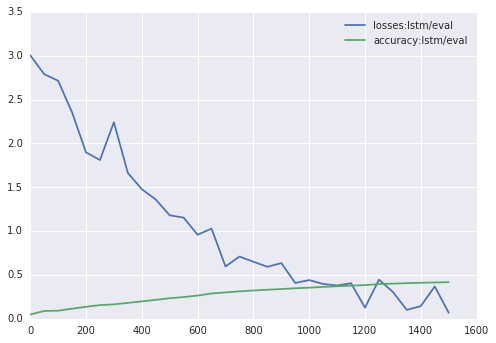

In [41]:
summary = Summary('lstm/eval')
summary.plot(['losses', 'accuracy'])

# Compare Model Performance

With DNN, we aggregate the words embeddings in each sentence. This appears more efficient and accurate. With LSTM, we have an overfitting problem. With both models produce the same loss value towards the end of the training, the accuracy on eval data is different.

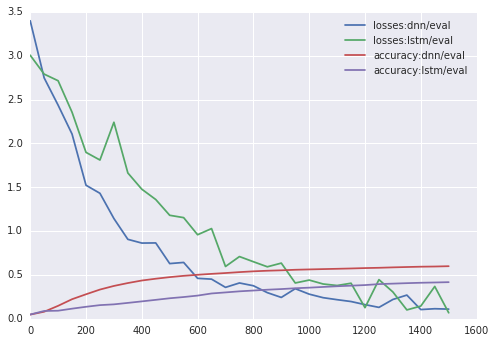

In [42]:
summary = Summary(['dnn/eval', 'lstm/eval'])
summary.plot(['losses', 'accuracy'])


Perhaps the results of LSTM model may get close to that of DNN with more training data. Also, it will probably helpful if we add a convlutional layer before LSTM layer.